# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [2]:
import os
os.chdir('/content/drive/My Drive/Computer Vision/Project_Face_Segmentation/Data/')
os.listdir()

['images.npy', 'model-1.94.h5']

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy', allow_pickle= True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [4]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224



### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (2 marks)

In [7]:
X_train.shape

(409, 224, 224, 3)

In [8]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

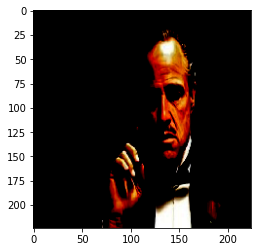

In [9]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

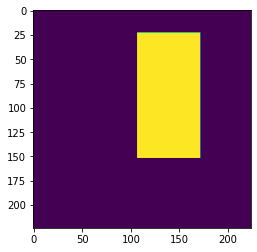

In [10]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tensorflow.__version__
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = 1.0, weights = 'imagenet')

    for layer in model.layers:
        layer.trainable = trainable
    
   
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
        
   
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    
   
    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [20]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable = False)

# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    
    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [25]:
model.fit(
    X_train,
    y=masks,
    batch_size=1,    
    epochs=20,
    callbacks=[checkpoint, reduce_lr, stop ]   
)                 

Epoch 1/20
409/409 [==============================] - ETA: 0s - loss: 2.0339 - dice_coefficient: 0.2691
Epoch 00001: loss improved from inf to 2.03392, saving model to model-2.03.h5
409/409 [==============================] - 16s 40ms/step - loss: 2.0339 - dice_coefficient: 0.2691 - lr: 1.0000e-04
Epoch 2/20
409/409 [==============================] - ETA: 0s - loss: 1.2060 - dice_coefficient: 0.4335
Epoch 00002: loss improved from 2.03392 to 1.20602, saving model to model-1.21.h5
409/409 [==============================] - 16s 40ms/step - loss: 1.2060 - dice_coefficient: 0.4335 - lr: 1.0000e-04
Epoch 3/20
409/409 [==============================] - ETA: 0s - loss: 1.0431 - dice_coefficient: 0.4933
Epoch 00003: loss improved from 1.20602 to 1.04306, saving model to model-1.04.h5
409/409 [==============================] - 16s 39ms/step - loss: 1.0431 - dice_coefficient: 0.4933 - lr: 1.0000e-04
Epoch 4/20
409/409 [==============================] - ETA: 0s - loss: 0.9689 - dice_coefficient: 0

Dice coefficient is 0.61. Lets increase the epochs from 20 to 30 & check whether there is increase in dice coefficient

In [44]:
model.fit(
    X_train,
    y=masks,
    batch_size=1,    
    epochs=30,
    callbacks=[checkpoint, reduce_lr, stop ]   
)    

Epoch 1/30
409/409 [==============================] - ETA: 0s - loss: 1.1631 - dice_coefficient: 0.4870
Epoch 00001: loss improved from inf to 1.16313, saving model to model-1.16.h5
409/409 [==============================] - 30s 74ms/step - loss: 1.1631 - dice_coefficient: 0.4870 - lr: 1.0000e-04
Epoch 2/30
409/409 [==============================] - ETA: 0s - loss: 0.7335 - dice_coefficient: 0.6341
Epoch 00002: loss improved from 1.16313 to 0.73346, saving model to model-0.73.h5
409/409 [==============================] - 31s 75ms/step - loss: 0.7335 - dice_coefficient: 0.6341 - lr: 1.0000e-04
Epoch 3/30
409/409 [==============================] - ETA: 0s - loss: 0.5798 - dice_coefficient: 0.6942
Epoch 00003: loss improved from 0.73346 to 0.57979, saving model to model-0.58.h5
409/409 [==============================] - 31s 75ms/step - loss: 0.5798 - dice_coefficient: 0.6942 - lr: 1.0000e-04
Epoch 4/30
409/409 [==============================] - ETA: 0s - loss: 0.5299 - dice_coefficient: 0

Dice coefficient has increased from 0.61 to 0.85

### Get the predicted mask for a sample image   (5 marks)

In [102]:
n = 10
sample_image = X_train[n]
WEIGHTS_FILE = "model-2.03.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.2), (IMAGE_WIDTH,IMAGE_HEIGHT))
pred_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


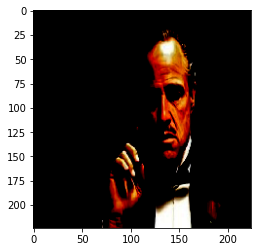

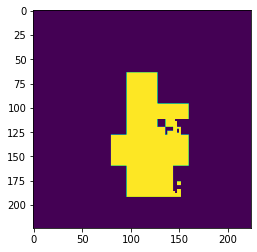

In [101]:
import matplotlib.pyplot as plt
plt.imshow(sample_image)
plt.show()
plt.imshow(pred_mask)